In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.metrics import AUC, Precision, Recall

In [2]:
import tensorflow
print(tensorflow.__file__)

C:\Users\ASUS\PycharmProjects\Graph Neural Network\.venv\lib\site-packages\tensorflow\__init__.py


In [10]:
import sys
print(sys.executable)
import tensorflow
print(tensorflow.__file__)

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\python.exe
None


In [3]:
import tensorflow as tf
print(tf.__path__)

['C:\\Users\\ASUS\\PycharmProjects\\Graph Neural Network\\.venv\\lib\\site-packages\\keras\\api\\_v2', 'C:\\Users\\ASUS\\PycharmProjects\\Graph Neural Network\\.venv\\lib\\site-packages\\keras\\_tf_keras', 'C:\\Users\\ASUS\\PycharmProjects\\Graph Neural Network\\.venv\\lib\\site-packages\\tensorflow_estimator\\python\\estimator\\api\\_v2', 'C:\\Users\\ASUS\\PycharmProjects\\Graph Neural Network\\.venv\\lib\\site-packages\\tensorboard\\summary\\_tf', 'C:\\Users\\ASUS\\PycharmProjects\\Graph Neural Network\\.venv\\lib\\site-packages\\tensorflow', 'C:\\Users\\ASUS\\PycharmProjects\\Graph Neural Network\\.venv\\lib\\site-packages\\tensorflow\\_api\\v2']


In [4]:
import tensorflow as tf

print(dir(tf))

['AggregationMethod', 'Assert', 'CriticalSection', 'DType', 'DeviceSpec', 'GradientTape', 'Graph', 'IndexedSlices', 'IndexedSlicesSpec', 'Module', 'Operation', 'OptionalSpec', 'RaggedTensor', 'RaggedTensorSpec', 'RegisterGradient', 'SparseTensor', 'SparseTensorSpec', 'Tensor', 'TensorArray', 'TensorArraySpec', 'TensorShape', 'TensorSpec', 'TypeSpec', 'UnconnectedGradients', 'Variable', 'VariableAggregation', 'VariableSynchronization', '_API_MODULE', '_KerasLazyLoader', '_LazyLoader', '__all__', '__builtins__', '__cached__', '__compiler_version__', '__cxx11_abi_flag__', '__cxx_version__', '__doc__', '__file__', '__git_version__', '__internal__', '__loader__', '__monolithic_build__', '__name__', '__operators__', '__package__', '__path__', '__spec__', '__version__', '_api', '_compat', '_current_file_location', '_current_module', '_distutils', '_estimator_module', '_fi', '_initializers', '_inspect', '_kernel_dir', '_ll', '_logging', '_losses', '_major_api_version', '_metrics', '_module_dir

In [2]:
# Tải data đã lưu
split_file = "splitted_data.pkl"
print("Tải dữ liệu đã lưu từ:", split_file)

with open(split_file, "rb") as f:
    data_splits = pickle.load(f)

# Lấy các tập dữ liệu từ dictionary
X_train = data_splits["X_train"]
X_val = data_splits["X_val"]
X_test = data_splits["X_test"]
y_train = data_splits["y_train"]
y_val = data_splits["y_val"]
y_test = data_splits["y_test"]
X_train_val = data_splits["X_train_val"]
y_train_val = data_splits["y_train_val"]

Tải dữ liệu đã lưu từ: splitted_data.pkl


In [3]:
# Kiểm tra phân phối của lớp
print("Phân phối lớp trong tập huấn luyện:")
unique, counts = np.unique(y_train_val, return_counts=True)
print(dict(zip(unique, counts)))
print(f"Tỷ lệ dữ liệu dương/âm: 1:{counts[0]/counts[1]:.2f}")

Phân phối lớp trong tập huấn luyện:
{0: 26815, 1: 169}
Tỷ lệ dữ liệu dương/âm: 1:158.67


In [28]:
# Áp dụng SMOTE để cân bằng dữ liệu (tùy chọn)
# Thử nghiệm với cả 2 cách: dùng SMOTE và dùng class weight
use_smote = False

if use_smote:
    print("Áp dụng SMOTE để cân bằng dữ liệu...")
    smote = SMOTE(random_state=42, sampling_strategy=0.5)  # Tăng lớp thiểu số lên đến 50% của lớp đa số
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_val, y_train_val)
    
    print("Phân phối lớp sau khi áp dụng SMOTE:")
    unique, counts = np.unique(y_train_resampled, return_counts=True)
    print(dict(zip(unique, counts)))
    
    # Sử dụng dữ liệu đã được cân bằng
    X_train_for_model = X_train_resampled
    y_train_for_model = y_train_resampled
else:
    # Tính class weight cho việc huấn luyện nếu không dùng SMOTE
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_val), y=y_train_val)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    print("Class weights:", class_weights_dict)
    
    # Tạo sample weights từ class_weights_dict
    sample_weights = np.array([class_weights_dict[int(label)] for label in y_train_val])
    
    # Sử dụng dữ liệu gốc
    X_train_for_model = X_train_val
    y_train_for_model = y_train_val

Class weights: {0: 0.5031512213313444, 1: 79.83431952662721}


In [38]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        """
        Focal Loss cho bài toán phân loại nhị phân.
        y_true: Ground truth (0 hoặc 1)
        y_pred: Xác suất dự đoán (sigmoid output)
        """
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.where(K.equal(y_true, 1), alpha, 1 - alpha)
        focal_weight = alpha_factor * K.pow(1 - p_t, gamma)
        
        loss = -focal_weight * K.log(p_t)
        return K.mean(loss)
    
    return focal_loss_fixed

In [48]:
from tensorflow.keras.layers import LeakyReLU
# Khởi tạo mô hình cải tiến
def create_improved_model(input_dim, l2_lambda=0.001):
    model = Sequential([
        # Tầng đầu tiên với nhiều neuron hơn và regularization
        Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dropout(0.3),

        # Tầng ẩn thứ hai
        Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dropout(0.3),

        # Thêm một tầng ẩn nữa
        Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dropout(0.2),

        # Tầng đầu ra
        Dense(1, activation='sigmoid')
    ])
    
    # model = Sequential([
    #     Dense(128, input_dim=input_dim, kernel_regularizer=l2(l2_lambda)),
    #     BatchNormalization(),
    #     LeakyReLU(alpha=0.01),
    #     Dropout(0.3),
    # 
    #     Dense(64, kernel_regularizer=l2(l2_lambda)),
    #     BatchNormalization(),
    #     LeakyReLU(alpha=0.01),
    #     Dropout(0.3),
    # 
    #     Dense(32, kernel_regularizer=l2(l2_lambda)),
    #     BatchNormalization(),
    #     LeakyReLU(alpha=0.01),
    #     Dropout(0.2),
    # 
    #     Dense(1, activation='sigmoid')
    # ])
    
    # Sử dụng optimizer Adam với learning rate thấp hơn
    optimizer = Adam(learning_rate=0.0005)
    
    # Compile với các metrics phù hợp cho dữ liệu không cân bằng
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        # loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )
    
    return model

In [49]:
# Tạo mô hình
improved_model = create_improved_model(X_train.shape[1])

# In kiến trúc mô hình
improved_model.summary()

# Chuẩn bị callbacks
early_stop = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               1408      
                                                                 
 batch_normalization_24 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_25 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_25 (Dropout)        (None, 64)               

In [50]:
# Huấn luyện mô hình
if use_smote:
    # Huấn luyện với dữ liệu SMOTE, không cần sample_weight
    history = improved_model.fit(
        X_train_for_model, y_train_for_model,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=1024,
        callbacks=[early_stop, reduce_lr],
        verbose=2
    )
else:
    # Huấn luyện với sample_weight
    history = improved_model.fit(
        X_train_for_model, y_train_for_model,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=1024,
        sample_weight=sample_weights,
        callbacks=[early_stop, reduce_lr],
        verbose=2
    )


# Dự đoán xác suất trên tập test
y_pred_proba = improved_model.predict(X_test)

Epoch 1/100
27/27 - 2s - loss: 0.9010 - accuracy: 0.5671 - auc: 0.6119 - precision: 0.0088 - recall: 0.6095 - val_loss: 0.9788 - val_accuracy: 0.6352 - val_auc: 0.7092 - val_precision: 0.0113 - val_recall: 0.6667 - lr: 5.0000e-04 - 2s/epoch - 79ms/step
Epoch 2/100
27/27 - 0s - loss: 0.8320 - accuracy: 0.5846 - auc: 0.6802 - precision: 0.0099 - recall: 0.6627 - val_loss: 0.8260 - val_accuracy: 0.8796 - val_auc: 0.7199 - val_precision: 0.0282 - val_recall: 0.5476 - lr: 5.0000e-04 - 192ms/epoch - 7ms/step
Epoch 3/100
27/27 - 0s - loss: 0.8281 - accuracy: 0.6112 - auc: 0.6848 - precision: 0.0100 - recall: 0.6213 - val_loss: 0.7413 - val_accuracy: 0.9017 - val_auc: 0.7322 - val_precision: 0.0331 - val_recall: 0.5238 - lr: 5.0000e-04 - 193ms/epoch - 7ms/step
Epoch 4/100
27/27 - 0s - loss: 0.7980 - accuracy: 0.6452 - auc: 0.7294 - precision: 0.0119 - recall: 0.6805 - val_loss: 0.7007 - val_accuracy: 0.9097 - val_auc: 0.7442 - val_precision: 0.0329 - val_recall: 0.4762 - lr: 5.0000e-04 - 220ms

Ngưỡng dự đoán tối ưu: 0.7675
Confusion Matrix:
 [[6497  208]
 [  29   13]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9956    0.9690    0.9821      6705
           1     0.0588    0.3095    0.0989        42

    accuracy                         0.9649      6747
   macro avg     0.5272    0.6393    0.5405      6747
weighted avg     0.9897    0.9649    0.9766      6747



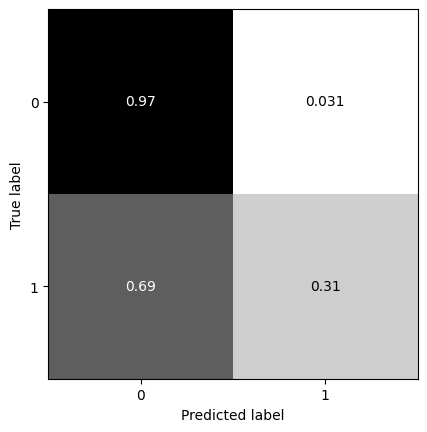

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay
# Tìm ngưỡng tối ưu sử dụng precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]

print(f"Ngưỡng dự đoán tối ưu: {optimal_threshold:.4f}")

# Áp dụng ngưỡng tối ưu
y_pred = (y_pred_proba > optimal_threshold).astype(int)

# Đánh giá mô hình
# Hiển thị ma trận nhầm lẫn
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true', 
    cmap='Greys',
    colorbar=False
)
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

In [13]:
# Tính ROC AUC và PR AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")


ROC AUC: 0.8717
PR AUC: 0.0533


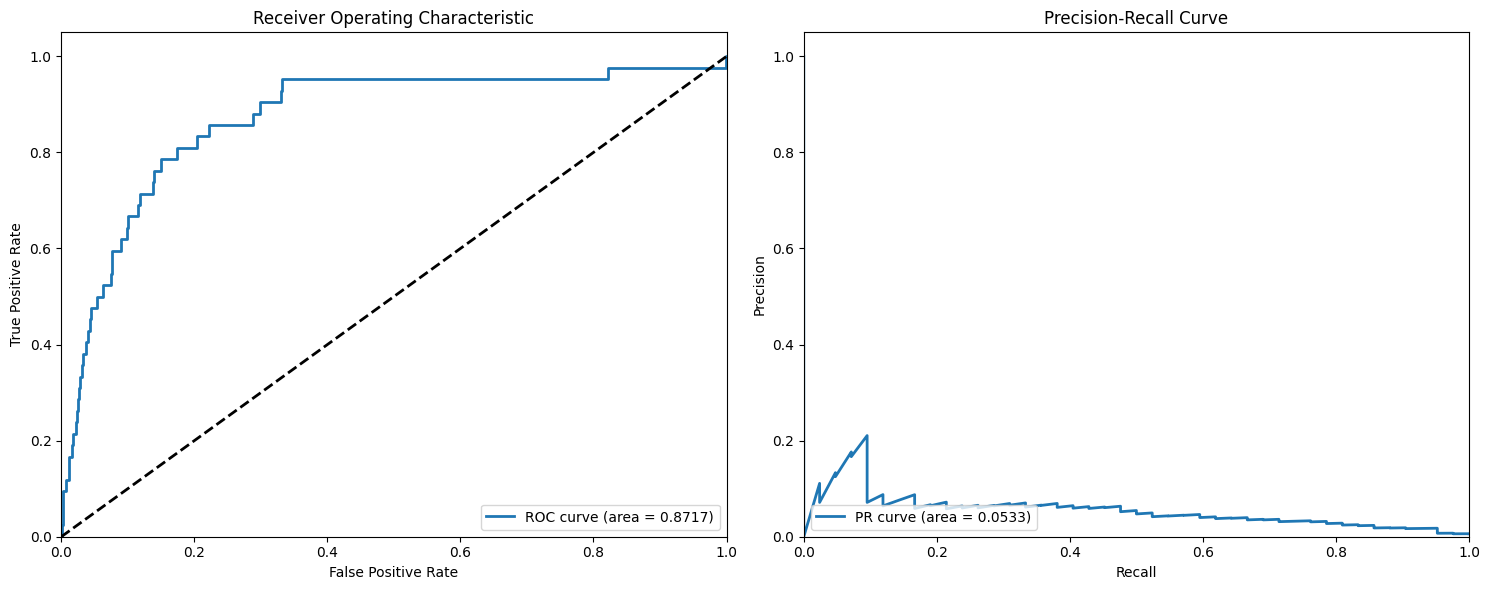

In [14]:
# Vẽ đường cong ROC và PR
def plot_curves(y_true, y_pred_proba):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    ax1.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], 'k--', lw=2)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right")
    
    # Precision-Recall Curve
    ax2.plot(recall, precision, lw=2, label=f'PR curve (area = {pr_auc:.4f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="lower left")
    
    plt.tight_layout()
    # plt.savefig('model_evaluation_curves.png')
    plt.show()

plot_curves(y_test, y_pred_proba)

In [ ]:
# Lưu mô hình và thông tin quan trọng
improved_model.save('fraud_detection_improved_model.h5')

model_info = {
    'optimal_threshold': optimal_threshold,
    'roc_auc': roc_auc,
    'pr_auc': pr_auc,
    'use_smote': use_smote
}

with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("Đã lưu mô hình và thông tin quan trọng.")

In [20]:
# Tính class weight cho việc huấn luyện
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
# print("Class weights:", class_weights_dict)

{0: 0.5031574760081547, 1: 79.67716535433071}


In [21]:
# Khởi tạo mô hình
# model = Sequential()
# model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='sigmoid'))  # Binary classification
# 
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# In kiến trúc mô hình
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Tạo sample weights từ class_weights_dict
# sample_weights = np.array([class_weights_dict[int(label)] for label in y_train])
# 
# Huấn luyện mô hình
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# 
# model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=100,
#     batch_size=2048,
#     sample_weight=sample_weights,
#     callbacks=[early_stop],
#     verbose=2
# )

Epoch 1/100
10/10 - 0s - loss: 150.5659 - accuracy: 0.3871 - val_loss: 134.3706 - val_accuracy: 0.1484 - 85ms/epoch - 8ms/step
Epoch 2/100
10/10 - 0s - loss: 341.3003 - accuracy: 0.3540 - val_loss: 204.1913 - val_accuracy: 0.2132 - 55ms/epoch - 6ms/step
Epoch 3/100
10/10 - 0s - loss: 134.0645 - accuracy: 0.3112 - val_loss: 258.6426 - val_accuracy: 0.2742 - 63ms/epoch - 6ms/step
Epoch 4/100
10/10 - 0s - loss: 103.9565 - accuracy: 0.3493 - val_loss: 267.0030 - val_accuracy: 0.3556 - 64ms/epoch - 6ms/step
Epoch 5/100
10/10 - 0s - loss: 113.3873 - accuracy: 0.3989 - val_loss: 262.4272 - val_accuracy: 0.4056 - 47ms/epoch - 5ms/step
Epoch 6/100
10/10 - 0s - loss: 121.5617 - accuracy: 0.4460 - val_loss: 260.1262 - val_accuracy: 0.4487 - 63ms/epoch - 6ms/step


In [26]:
# Dự đoán và đánh giá
# y_pred = (model.predict(X_test) > 0.5).astype(int)
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

211/211 [==============================] - 0s 921us/step
[[ 955 5750]
 [   2   40]]
              precision    recall  f1-score   support

           0     0.9979    0.1424    0.2493      6705
           1     0.0069    0.9524    0.0137        42

    accuracy                         0.1475      6747
   macro avg     0.5024    0.5474    0.1315      6747
weighted avg     0.9917    0.1475    0.2478      6747

